# Prediction intervals in Agile forecasting

## Why we need to estimate next sprint velocity?

In projects Scrum Masters and Delivery managers often need to estimate a velocity of the team during next sprint. Even in agile approach client's would like to know what they can expect from next release. From the other hand it's good if SM could assess how much a team can deliver to propose sprint goal and stretched goals to challenge a team.

## Forecast 3 last sprints average

According to Scrum Book (http://scrumbook.org/value-stream/running-average-velocity.html) running average (moving average, rolling average) could be a good start when forecasting future velocity. I'd use Python to calculate 3 sprints running average for the example data (forecastedVelocity). In the forecastError column you can find difference between actual and forecasted value.


In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

closedSprints = pd.read_csv('sprints.csv', delimiter=';')
closedSprints.head()

# calculate rolling average of 3 last ratios
closedSprints['forecastedVelocity'] =  np.round(closedSprints['velocity'].shift().rolling(3, min_periods=1).mean(), 2)
closedSprints['forecastError'] = closedSprints['velocity'] - closedSprints['forecastedVelocity']

closedSprints.head()



,sprintNo,velocity,forecastedVelocity,forecastError
0,0,12.0,NaN,NaN
1,1,14.0,12.00,2.00
2,2,10.0,13.00,-3.00
3,3,14.0,12.00,2.00
4,4,16.0,12.67,3.33


I'm using first predicted value as a forecast for 3 future sprints.

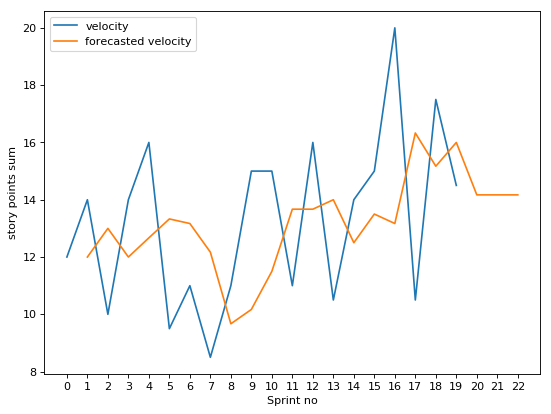

In [107]:
lastForecast = closedSprints.loc[closedSprints['sprintNo'] == 20, 'forecastedVelocity'].iat[0]
closedSprints.loc[closedSprints['sprintNo'].isin([21,22]), 'forecastedVelocity'] = lastForecast

figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

_ = plt.xticks( closedSprints.index.values , closedSprints.sprintNo ) # location, labels
_ = plt.plot( closedSprints['velocity'])
_ = plt.plot( closedSprints['forecastedVelocity'])

_ = plt.xlabel('Sprint no')
_ = plt.ylabel('story points sum')
_ = plt.legend(['velocity', 'forecasted velocity'])
_ = plt.show()
                                 

## Adding prediction interval

Above you can find the historical sprint data with calculated forecasted velocity. This calculated forecast is in a middle of possible forecast values. It's always recommended (https://otexts.org/fpp2/perspective.html#perspective) to calculate prediction intervals to understand the range of possible forecasted values. This should give us additional insight and confidence in the model and evalate forecast accuracy.

To calculate prediction intervals we need to calculate standard deviation of forecast errors(https://otexts.org/fpp2/prediction-intervals.html).

In [108]:
errorStd = round(closedSprints.forecastError.std(), 2)
print('Forecast error standard deviation: {}'.format(errorStd))

Forecast error standard deviation: 3.45


To simplify I'm assuming that forecast error is following normal distribution. To calculate uncertainty of forecasts I'm using 1.96 multiplier for 95% confidence interval and 1.44 multiplier for 85% confidence interval. Values for other intervals can be found here: https://otexts.org/fpp2/prediction-intervals.html

Generally forecast uncertainty should grow with time but I didn't included this factor to simplify calculations.

In [109]:

closedSprints.loc[closedSprints['sprintNo'].isin([20, 21, 22]), 'min95'] = (lastForecast 
                                                                            - 1.96 * errorStd).clip(0)
closedSprints.loc[closedSprints['sprintNo'].isin([20, 21, 22]), 'max95'] = lastForecast + 1.96 * errorStd

closedSprints.loc[closedSprints['sprintNo'].isin([20, 21, 22]), 'min85'] = (lastForecast 
                                                                            - 1.44 * errorStd).clip(0)
closedSprints.loc[closedSprints['sprintNo'].isin([20, 21, 22]), 'max85'] = lastForecast + 1.44 * errorStd


closedSprints.tail()

,sprintNo,velocity,forecastedVelocity,forecastError,min95,max95,min85,max85
18,18,17.5,15.17,2.33,NaN,NaN,NaN,NaN
19,19,14.5,16.00,-1.50,NaN,NaN,NaN,NaN
20,20,NaN,14.17,NaN,7.408,20.932,9.202,19.138
21,21,NaN,14.17,NaN,7.408,20.932,9.202,19.138
22,22,NaN,14.17,NaN,7.408,20.932,9.202,19.138


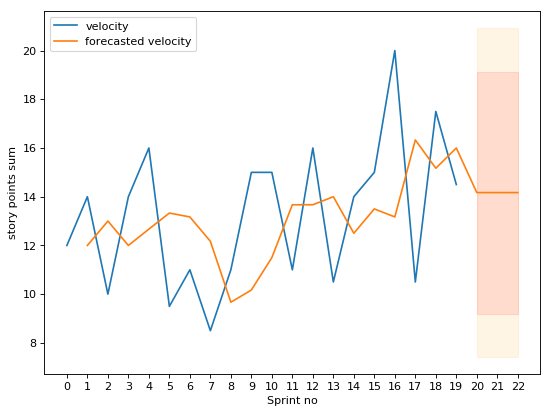

In [110]:
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

_ = plt.xticks( closedSprints.index.values , closedSprints.sprintNo ) # location, labels
_ = plt.plot( closedSprints['velocity'])
_ = plt.plot( closedSprints['forecastedVelocity'])
#_ = plt.plot( closedSprints['min95'])
#_ = plt.plot( closedSprints['max95'])
_ = plt.fill_between(closedSprints.index.values, closedSprints['min95'], closedSprints['max95'], color='orange', alpha='0.1')
_ = plt.fill_between(closedSprints.index.values, closedSprints['min85'], closedSprints['max85'], color='red', alpha='0.1')


_ = plt.xlabel('Sprint no')
_ = plt.ylabel('story points sum')
_ = plt.legend(['velocity', 'forecasted velocity'])
_ = plt.show()


As you can see above 95% prediction interval (orange) on the diagram is wider than 85% interval (red). According to calculation 95 times in 100 observations the delivered velocity should be between 7.4 and 20.9 story points. Using this information we could plan accordingly when features will be delivered by the team.

## Ideas on how to improve confidence intervals

As you can see above prediction interval is quite wide. From definition we know that it's directly affected by forecast error. What you can do to minimize the error? First of all I'd recommend using more sophisticated forecast methods than rolling average from last 3 sprints. This may be good start but in real life practice it's usually too simple, because it's not taking into consideration factors like team capacity, structure etc. There should be other models that could give better results. In next articles I should demonstrate how they could be easily used.

Another suggestion is to reduce story size. This should have several advantages: 
* earlier feedback from stakeholders when following MVP approach
* reduced fluctuation in story points delivered sprint to sprint or period to period (in case of kanban approach). 
With larger stories it's easy to miss sprint end date. This could cause large differences between sprint velocities and would make it less predictable

## Measure and improve!
As you can see above prediction intervals might be extremely useful to understand deliverables forecast for agile teams. If you need to be confident when planning you should add this tool to your quiver.

